# Pytorch Tutorial for Python Beginner but Strong in Math

This tutorial is exclusive for moderate math programmer. Before everytinh started, Let's Play the Neural network first

In [1]:
%%html
<iframe src="https://playground.tensorflow.org" width="100%" height="800"></iframe>

Playground is good example to show how the neural network works and how much parameters for adjusting for specific classification
<br>

Within the neuron unit, it roles the human nervous function that receives multi-nodes signal and do some sum operation with activate further signal to next neuron node. With this, a cluster of neurons called Neural Networks.

![](ann.png)

As you see, the need of activation function is essential to activate the sum of signals in order to pulse next signal. There are several types of activation functions that work differently.

![](https://miro.medium.com/v2/resize:fit:1200/1*ZafDv3VUm60Eh10OeJu1vw.png)

After we play with the Neural network, let's make some intuition for modeling in Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

For acceleration, we can check GPU-enabled by this code

In [3]:
torch.cuda.is_available()

False

In case MacOS

In [4]:
torch.backends.mps.is_available()

True

Finally, automating define the device to model

In [5]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
    
print(f'Using device: {device}')

Using device: mps


Make some sample dataset for classification problem. Noted that the generated dataset is `numpy.ndarray`

In [6]:
# Generate a classification problem with 2 informative features
X, y = make_blobs(n_samples=300, centers=5)

In [11]:
X.shape, y.shape

(torch.Size([300, 2]), torch.Size([300]))

What is blob looks like

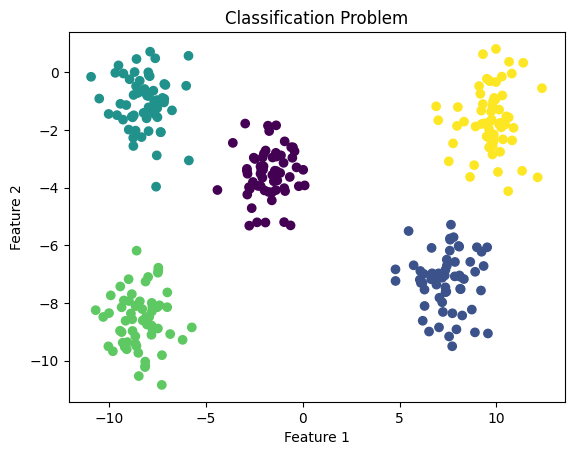

In [7]:
# Plot the decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Problem')
plt.show()

Comes to first pytorch routine, there are conversion from `numpy.ndarray` to `torch.Tensor`

In [8]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

Let's to create a model. Torch is not like `tensorflow` or `keras` that creates sequential template to compose the model. torch model rely on `nn.Module` class to define what are layers and how to forward the data.

Let's define the simple Deep Neural Networks as example

Since we have the blob dataset that has 500 samples, 2 features to classify 5 clases.

We make a intermidiate 2 linear layers. that get 2 input and 5 output nodes as figure

<img src="ann2.png" alt="drawing" style="width:50%;"/>

You may see the model is depend on layer connectivity. The neural network is defined based on the weight connection. Therefore, There are 3 FC (Fully-Connected) layers with ReLU Activation

In [13]:
# Create Simple Model

class MyModel(nn.Module): # Name the class
    
    def __init__(self, input_feature, output_feature): # Constructor
        super(MyModel, self).__init__() # Ignore this
        
        # Feeding forward layers
        self.fc1 = nn.Linear(input_feature, 100) # Layer 1 (input)
        self.fc2 = nn.Linear(100, 100) # Layer 2
        self.fc3 = nn.Linear(100, output_feature)  # Layer 3 (output)
        
        # Intermidiate layers
        self.relu = nn.ReLU()  # Activation function
        self.softmax = nn.Softmax() # Output function


    def forward(self, x): # Define how the model forwarding
        
        x = self.fc1(x) # input to layer 1
        x = self.relu(x) # activate output from layer 1
        
        x = self.fc2(x) # feed to layer 2
        x = self.relu(x) # activate output from layer 2
        
        x = self.fc3(x) # feed to layer 3 (output)
        x = self.softmax(x) # activate output from layer 2
        
        return x

After declare the model template as class, we initialize the instance of model by assigning the model with parameters of 2 inputs and 5 outputs. We define the Cross Entropy Loss Function as cost function to measure the error of the model. Then, optimizer will calculate weights for learning

In [14]:
# Create the model, loss function, and optimizer

model = MyModel(input_feature=2, output_feature=5) # create model instance

criterion = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss

optimizer = optim.Adam(model.parameters(), lr=0.001) #  Mathematic model to adjust weight

Check the model summary to show model parameters and size in memory

In [15]:
summary(model, input_size = (2, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
              ReLU-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          10,100
              ReLU-4                  [-1, 100]               0
            Linear-5                    [-1, 5]             505
           Softmax-6                    [-1, 5]               0
Total params: 10,905
Trainable params: 10,905
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


We can test the model feedforward by `model(x)` by random input for testing whether any error occurred in the model

In [19]:
x = torch.rand(5, 2)

model(x)

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.2119, 0.1994, 0.2051, 0.2095, 0.1741],
        [0.2117, 0.1999, 0.2042, 0.2091, 0.1750],
        [0.2102, 0.1944, 0.2085, 0.2188, 0.1680],
        [0.2121, 0.1970, 0.2054, 0.2125, 0.1731],
        [0.2130, 0.1981, 0.2108, 0.2114, 0.1667]], grad_fn=<SoftmaxBackward0>)

If there is no error in the model, it should show the output in array shape (m, classes))

Before training model, we need some configuration for training steps. we move the model to device and define the number of epochs to train the model

In [20]:
model = model.to(device) # Move model parameters to specific device

epochs = 300 # declare number of epochs of training

print_interval = 10 # print metric every ... epoch

The training model step requires more comprehesive for loop control. We loop over `N` epochs and feed forward wih `model(X)` then check the loss `criterion(y_predict, y_actual)`. This step error of model is calculated. We do back-propagation by set gradient to zero `optimizer.zero_grad()` then calculate gradients by `loss.backward()` for `optimizer.step()` to adjust weights in the model. we can print the loss value by `loss.item()`

In [21]:
for epoch in range(epochs): # Looping over epochs

    # Forward pass
    outputs = model(X.to(device)) # feed forward
    loss = criterion(outputs.squeeze(), y.to(device)) # measure loss

    # Backward and optimize
    optimizer.zero_grad() # reset gradients
    loss.backward() # calculate loss
    optimizer.step() # adjust weights

    # print metrics
    if (epoch+1) % print_interval == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/300], Loss: 1.3077
Epoch [20/300], Loss: 1.1197
Epoch [30/300], Loss: 1.0508
Epoch [40/300], Loss: 1.0115
Epoch [50/300], Loss: 0.9860
Epoch [60/300], Loss: 0.9679
Epoch [70/300], Loss: 0.9548
Epoch [80/300], Loss: 0.9454
Epoch [90/300], Loss: 0.9384
Epoch [100/300], Loss: 0.9326
Epoch [110/300], Loss: 0.9278
Epoch [120/300], Loss: 0.9236
Epoch [130/300], Loss: 0.9198
Epoch [140/300], Loss: 0.9168
Epoch [150/300], Loss: 0.9147
Epoch [160/300], Loss: 0.9130
Epoch [170/300], Loss: 0.9117
Epoch [180/300], Loss: 0.9107
Epoch [190/300], Loss: 0.9099
Epoch [200/300], Loss: 0.9093
Epoch [210/300], Loss: 0.9088
Epoch [220/300], Loss: 0.9084
Epoch [230/300], Loss: 0.9081
Epoch [240/300], Loss: 0.9078
Epoch [250/300], Loss: 0.9075
Epoch [260/300], Loss: 0.9073
Epoch [270/300], Loss: 0.9071
Epoch [280/300], Loss: 0.9069
Epoch [290/300], Loss: 0.9068
Epoch [300/300], Loss: 0.9067


The model run like this until last epochs. Next is to evaluate the model performance. It is nothing but feed forward without calculating gradients and adjusting weights. However, the model this step does not need heavy processing power. For more convience in output comparison, we move the model to `cpu` to predict the output and use `torch.max` function to find max probabilities from a row of probability in softmax class

In [22]:
# Evaluation

model = model.to('cpu') # Move to model parameters to cpu

with torch.no_grad(): # tell the model that don't calculate gradients
    
    model.eval() # tell the model that this is testing mode (disable dropout etc.)
    
    outputs = model(X) # Try feeding forward
    _, predicted = torch.max(outputs.data, 1) # get class_id
    
    
print(classification_report(y, predicted))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Since we make blob dataset randomly, we can get different result based on complexity of dataset. For more understanding, we print out what output from `model(x)` and what is predictd by `torch.max`. you may see that index of max index of a row of class probailities show in answer of predicted

In [28]:
torch.set_printoptions(sci_mode=False)

print(outputs[:5])
print(predicted[:5])

tensor([[    0.9995,     0.0002,     0.0000,     0.0002,     0.0000],
        [    0.0004,     0.0000,     0.9996,     0.0001,     0.0000],
        [    0.9983,     0.0002,     0.0001,     0.0014,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     1.0000],
        [    0.0000,     0.0000,     1.0000,     0.0000,     0.0000]])
tensor([0, 2, 0, 4, 2])


This is a bonus for more visually representation. Noted that this can only drawn from 2 features plot. This called _Decision Boundary_ which represent the decisive area of classes interpretation by given feature maps

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


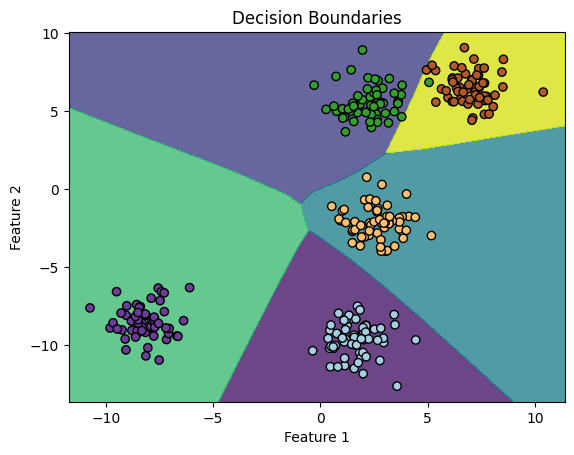

In [15]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))


# Convert the meshgrid to a PyTorch tensor
X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

# Make predictions on the meshgrid
with torch.no_grad():
    model.eval()
    Z = model(X_grid)
    _, predicted = torch.max(Z.data, 1)
    Z = predicted.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundaries')
plt.show()

As shown, this is a easiest example of deep learning mode development for training and evaluation. In reality, model is not simple like this. There are some challenges in DL to achieve. We are going to do next

# Learning Layers


### Linear layer

As example above, linear layer referes to a connection between fully-connected (FC) nodes each other. we would make more comprehensive about this

In [36]:
linear_layer = nn.Linear(2, 3)

try making a random tensor matrix

In [37]:
x = torch.rand(5, 2)

print(x)
print(x.size())

tensor([[0.3487, 0.2497],
        [0.4972, 0.1333],
        [0.8490, 0.9731],
        [0.5133, 0.8818],
        [0.6316, 0.9952]])
torch.Size([5, 2])


forward the x

In [38]:
h = linear_layer(x)

Check the output from linear layer

In [39]:
print(h)
print(h.shape)

tensor([[ 0.5109, -0.9166,  0.4748],
        [ 0.5002, -0.9915,  0.4720],
        [ 0.5165, -1.2538,  0.3390],
        [ 0.5275, -1.0575,  0.3856],
        [ 0.5266, -1.1328,  0.3600]], grad_fn=<AddmmBackward0>)
torch.Size([5, 3])


It is nothing but `linear_layer` is a weight with bias shape (out, in) as result (3, 2)

In [46]:
linear_layer.weight

Parameter containing:
tensor([[-0.0427,  0.0373],
        [-0.5643, -0.0760],
        [-0.1079, -0.1131]], requires_grad=True)

same as bias

In [47]:
linear_layer.bias

Parameter containing:
tensor([ 0.5165, -0.7008,  0.5407], requires_grad=True)

Remember in previous sesstion? neural network is actually simply algebra function in formula

$$
y = W^TX + b
$$

denote to

$$
h_\theta(x) = \theta_0 + \theta_1x
$$

We apply same formula to above computation. we get

In [57]:
linear_layer.bias + x @ linear_layer.weight.T

tensor([[ 0.5109, -0.9166,  0.4748],
        [ 0.5002, -0.9915,  0.4720],
        [ 0.5165, -1.2538,  0.3390],
        [ 0.5275, -1.0575,  0.3856],
        [ 0.5266, -1.1328,  0.3600]], grad_fn=<AddBackward0>)

Check the answer above of `linear_layer(x)` to see how different

# Convolutional Neural Networks (CNN)

This is a different way to compute the multi-dimensional representation which usually do in sequenctial of image-like data. Most of the CNNs are employed are 1-DCNN and 2-DCNN. we are going through one by one

## 1-DCNN

CNN is simply moving window over the sequence of an input in case the input has shape 1-D (with feature is second dimension). 

<br>

1-DCNN is a simplest implementation for time-series data analysis. It convolutes the moving kernel and multiply and sum into a new value for output array. Suppose we have declare `Conv1d` with 2 features and output 3 features by `kernel_size` 3

In [59]:
conv1d_layer = nn.Conv1d(in_channels=2, out_channels=3, kernel_size=3)

![](https://krzjoa.github.io/post/2019-12-28-pytorch-ts-v1/conv1d.gif)

We make a random data by (m, 2, 12)

In [69]:
x = torch.rand(5, 2, 12) # (batch, channel, timestep)

Forward the `x` in `conv1d_layer`

In [70]:
h = conv1d_layer(x)

Check the shape

In [71]:
conv1d_layer(x).shape

torch.Size([5, 3, 10])

You may see the output is shape (m, 3, 10) which `3` means output channels we declared, but 12 timestep reduces to 10 timestep due to no `padding`. See this calculation [Conv1d Doc](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) and make this function

In [72]:
def calc_out_l_conv1d(l_in, padding, dilation, kernel_size, stride):
    
    return int(((l_in + 2* padding - dilation * (kernel_size - 1) - 1) / stride) + 1)

When apply this function this proved that time dimension reduce to 10 because of no padding

In [73]:
calc_out_l_conv1d(l_in=12, padding=0, dilation=1, kernel_size=3, stride=1)

10

To keep timestep as equal as original, we need `padding = 1` 

In [74]:
calc_out_l_conv1d(l_in=12, padding=1, dilation=1, kernel_size=3, stride=1)

12

Prove this

In [75]:
conv1d_layer_pad = nn.Conv1d(in_channels=2, out_channels=3, kernel_size=3, padding=1)

conv1d_layer_pad(x).shape

torch.Size([5, 3, 12])

padding will help to observe all features in a sequence without lost the feature map dimension. But the data scientist usually not pay attention to the padding much because we care only channel out which indicates directly to how deep the model can learn from the data

## 2-DCNN

2DCNN is same as 1DCNN but do with 2D data like image for example. See this intput first

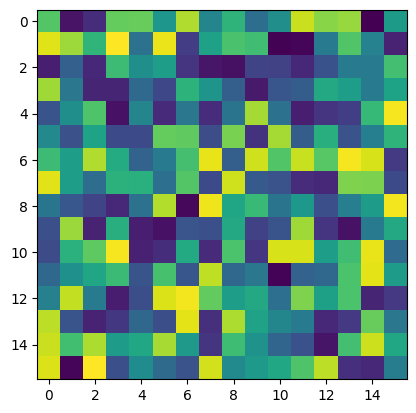

In [82]:
x = torch.rand(5, 1, 16, 16)

plt.imshow(x[0, 0, :, :])

we declare a random number of image-like data shape 16x16 (height, width) with 1 channel for 5 samples in a batch.

<br>

2D Convolutional Neural Network has a kernel as the weight layers that convolute the data into a feature map (works like 1DCNN but 2D) like in figure

![](https://miro.medium.com/v2/resize:fit:790/1*1okwhewf5KCtIPaFib4XaA.gif)

![](https://miro.medium.com/v2/resize:fit:1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)

Try declare a `nn.Conv2d` instance by 1 channel in and 3 channel out, kernel size 3

In [83]:
conv2d_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

Try feedforward

In [84]:
h = conv2d_layer(x)

check the shape

In [86]:
h.shape

torch.Size([5, 3, 14, 14])

You notice that there are 3 channel as in layer instance, but image dim reduces to 14, 14. This happen as same as 1DCNN. Follow the [Conv2d Doc](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and make the function

In [96]:
def calc_out_hw_conv2d(dim, padding, dilation, kernel_size, stride):
    
    h_out = ((dim[0] + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0]) + 1
    w_out = ((dim[1] + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1]) + 1
    
    return int(h_out), int(w_out)

Prove the assumption

In [98]:
calc_out_hw_conv2d((16, 16), padding=(0,0), dilation=(1,1), kernel_size=(3,3), stride=(1,1))

(14, 14)

So, to keep dimension of image input use `padding = 1`

In [99]:
calc_out_hw_conv2d((16, 16), padding=(1,1), dilation=(1,1), kernel_size=(3,3), stride=(1,1))

(16, 16)

Prove it

In [100]:
conv2d_layer_pad = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)

conv2d_layer_pad(x).shape

torch.Size([5, 3, 16, 16])

## RNN and LSTM

This is a module to exclusively analyze the sequence data like text or sequence-relation (e.g. time-series)

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*M3MaZYndVKEfOG7R.png)

It iterates each of item in a sequence one by one

![](https://miro.medium.com/v2/resize:fit:934/format:webp/1*wY7pdZgqzE3huCE5adFLXw.png)


Suppose we initialize RNN unit with 2 `input_size` with 2 `hiden_size`

In [153]:
rnn_layer = nn.RNN(input_size=2, hidden_size=3, batch_first=True)

Make a random x

In [320]:
x = torch.rand(5, 12, 2) # (batch, sequence, feature)

Try feedforward

In [162]:
out, h_n = rnn_layer(x)

Check the output shape

In [163]:
out.shape, h_n.shape

(torch.Size([5, 12, 3]), torch.Size([1, 5, 3]))

There are 2 results, one is `out` which is the hidden state for every sequence where `h_n` is a last hidden state through the rnn learning. To prove this, print out the hidden state of `out` at last item in a sequence and print out the `h_n` which has only 1 item

In [165]:
out[:, -1, :], h_n

(tensor([[-0.1442, -0.8178,  0.0650],
         [-0.3389, -0.7832,  0.0510],
         [-0.3197, -0.7893,  0.1083],
         [-0.3991, -0.7591,  0.0896],
         [-0.3311, -0.7556,  0.1095]], grad_fn=<SliceBackward0>),
 tensor([[[-0.1442, -0.8178,  0.0650],
          [-0.3389, -0.7832,  0.0510],
          [-0.3197, -0.7893,  0.1083],
          [-0.3991, -0.7591,  0.0896],
          [-0.3311, -0.7556,  0.1095]]], grad_fn=<StackBackward0>))

You will see that they are same. This means that it depends on the modeling way we can use only last hidden state vector to learn in FC layer or use every hidden state vector to learn every step of hidden state.

<br>

For example, use last hidden state

In [167]:
h_n # (batch, hidden_size)

tensor([[[-0.1442, -0.8178,  0.0650],
         [-0.3389, -0.7832,  0.0510],
         [-0.3197, -0.7893,  0.1083],
         [-0.3991, -0.7591,  0.0896],
         [-0.3311, -0.7556,  0.1095]]], grad_fn=<StackBackward0>)

Or use every hidden state

In [180]:
out.reshape(5, -1).shape

torch.Size([5, 36])

## LSTM Layer

For more understanding in Thai [Thai LSTM](https://sirawich99.medium.com/%E0%B8%AA%E0%B8%A3%E0%B8%B8%E0%B8%9B%E0%B8%84%E0%B8%A7%E0%B8%B2%E0%B8%A1%E0%B9%80%E0%B8%82%E0%B9%89%E0%B8%B2%E0%B9%83%E0%B8%88-rnn-lstm-gru-24-10-2020-95602afe3053)

Long Short-Term Memory (LSTM) is a advanced version of RNN. RNN previously use only a single linear equation for passing through a sequence of features. This causes foget problems when long sequence length. LSTM is there to have additional term called _Cell State_ more than _Hidden State_. This Cell State controls LSTM unit combining with activateion functions and concatetation terms to make decision for the unit to calculate next hidden state

![](https://www.researchgate.net/publication/329362532/figure/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg)

By this diffuculty, we can skip calculation from scratch, and let's started how to use it. Suppose to declare a unit of LSTM with same input size 2 and hidden size 3


In [239]:
lstm_layer = nn.LSTM(input_size=2, hidden_size=3, batch_first=True)

LSTM receive same shape as RNN which is (batch, seq, feature) but the output is different from RNN

In [240]:
out, (h_n, c_n) = lstm_layer(x)

Check the shape

In [237]:
out.shape, h_n.shape, c_n.shape

(torch.Size([5, 12, 3]), torch.Size([1, 5, 3]), torch.Size([1, 5, 3]))

You notice that h_n and c_n are same shape due to it work in a LSTM unit. To use output of LSTM, we can simlarly use `out` directly but use only last hidden state by `out[:, -1, :]` which is same has `h_n`

In [241]:
out[:, -1 , :], h_n

(tensor([[ 0.3902,  0.4272, -0.1628],
         [ 0.4657,  0.4007, -0.1447],
         [ 0.3948,  0.4115, -0.1446],
         [ 0.4783,  0.3990, -0.1344],
         [ 0.4690,  0.4180, -0.1518]], grad_fn=<SliceBackward0>),
 tensor([[[ 0.3902,  0.4272, -0.1628],
          [ 0.4657,  0.4007, -0.1447],
          [ 0.3948,  0.4115, -0.1446],
          [ 0.4783,  0.3990, -0.1344],
          [ 0.4690,  0.4180, -0.1518]]], grad_fn=<StackBackward0>))

However, LSTM can also works by multiple layers of LSTM which pass the hidden state from one layer to next layer (depth). Try to declare same LSTM but `num_layers=2`

In [242]:
lstm_layer_n2 = nn.LSTM(input_size=2, hidden_size=3, batch_first=True, num_layers=2)

![](https://i.sstatic.net/SjnTl.png)

Try feedforward

In [243]:
out, (h_n, c_n) = lstm_layer_n2(x)

Check the shape

In [244]:
out.shape, h_n.shape, c_n.shape

(torch.Size([5, 12, 3]), torch.Size([2, 5, 3]), torch.Size([2, 5, 3]))

Notice that `h_n` and `c_n` have more `num_layers` in `(num_layer, batch, hiden_size)`. we however use the last output from `out[:, -1, :]` or `h_n[-1, :, :]` which are same things

In [247]:
out[:, -1, :], h_n[-1, :, :]

(tensor([[-0.1097, -0.1452, -0.3529],
         [-0.1049, -0.1556, -0.3614],
         [-0.1092, -0.1537, -0.3538],
         [-0.1048, -0.1241, -0.3583],
         [-0.1058, -0.1356, -0.3563]], grad_fn=<SliceBackward0>),
 tensor([[-0.1097, -0.1452, -0.3529],
         [-0.1049, -0.1556, -0.3614],
         [-0.1092, -0.1537, -0.3538],
         [-0.1048, -0.1241, -0.3583],
         [-0.1058, -0.1356, -0.3563]], grad_fn=<SliceBackward0>))

As well as `bidirectional=True`, LSTM can also turn over direction of feedforward go and back in the data sequence. Try to declare this

In [325]:
lstm_layer_bi = nn.LSTM(input_size=2, hidden_size=3, batch_first=True, bidirectional=True, num_layers=1)

![](https://miro.medium.com/v2/resize:fit:680/1*sf4vCzcyycSe7GC3dZ2u2w.png)

Feedforward

In [326]:
out, (h_n, c_n) = lstm_layer_bi(x)

Check shape

In [327]:
out.shape, h_n.shape, c_n.shape

(torch.Size([5, 12, 6]), torch.Size([2, 5, 3]), torch.Size([2, 5, 3]))

Since we define `hidden_size=3` the output show `(batch, seq, dir*hidden_size)` we can also use the output hidden_state from this

In [328]:
out[:, -1, :]

tensor([[-0.2727,  0.1554,  0.3375, -0.1259,  0.0819,  0.0940],
        [-0.3006,  0.1624,  0.3257, -0.1234,  0.1197,  0.0911],
        [-0.2788,  0.1781,  0.2612, -0.1016,  0.0967,  0.1086],
        [-0.2765,  0.1767,  0.2761, -0.1149,  0.0769,  0.1018],
        [-0.2674,  0.1844,  0.2741, -0.0854,  0.0797,  0.1213]],
       grad_fn=<SliceBackward0>)

# Excercise: MNIST Classification

Do hand writing dataset using CONV2D Layers to classify number

In [310]:
from sklearn import datasets

digits = datasets.load_digits()
pd = datasets.load_digits()

data = digits.data.reshape(-1, 8, 8)
target = digits.target

In [216]:
data.shape

(1797, 8, 8)

In [217]:
target.shape

(1797,)

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_78308/1803378137.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


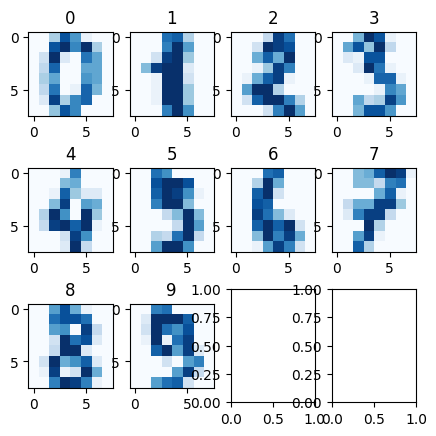

In [273]:
fig, ax = plt.subplots(3, 4, figsize=(5, 5))

ax = ax.flatten()

for i in range(10):
    
    ax[i].imshow(data[i], cmap='Blues')
    ax[i].set_title(f'{target[i]}')
    
fig.show()

First of all we have to design the network based on input data

In [278]:
x = torch.from_numpy(data[0]).float()
x.shape

torch.Size([8, 8])

In [279]:
x = x[None, None, :, :]
x.shape

torch.Size([1, 1, 8, 8])

In [280]:
conv2d_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)

h = conv2d_1(x)

h.shape

torch.Size([1, 3, 6, 6])

In [281]:
relu = nn.ReLU()

h = relu(h)

In [282]:
conv2d_2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)

h = conv2d_2(h)

h.shape

torch.Size([1, 6, 4, 4])

In [283]:
h = relu(h)

In [284]:
h = h.reshape(-1, 6*4*4)

h.shape

torch.Size([1, 96])

In [285]:
fc_1 = nn.Linear(96, 100)

h = fc_1(h)

h.shape

torch.Size([1, 100])

In [286]:
fc_out = nn.Linear(100, 10)

h = fc_out(h)

h.shape

torch.Size([1, 10])

In [287]:
h

tensor([[ 0.3930, -0.2568,  0.1349, -0.2857,  0.2457, -0.2092,  0.0382,  0.2893,
          0.1186, -0.3989]], grad_fn=<AddmmBackward0>)

In [289]:
_, pred = torch.max(h, 1)

pred

tensor([0])

In [302]:
# Create Simple Model

class MNISTModel(nn.Module): # Name the class
    
    def __init__(self, ): # Constructor
        super(MNISTModel, self).__init__() # Ignore this
        
        # Code here ...
        
        self.conv2d_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.conv2d_2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        
        self.relu = nn.ReLU()
        
        self.fc_1 = nn.Linear(96, 100)
        self.fc_out = nn.Linear(100, 10)

    def forward(self, x): # Define how the model forwarding
        
        # Code here ...
        
        h = self.conv2d_1(x)
        h = self.relu(h)
        
        h = self.conv2d_2(h)
        h = self.relu(h)
        
        h = h.reshape(-1, 6*4*4)
        
        h = self.fc_1(h)
        h = self.fc_out(h)
        
        return h

In [303]:
# Create the model, loss function, and optimizer

model = MNISTModel() # create model instance

criterion = nn.CrossEntropyLoss()  # Binary Cross-Entropy Loss

optimizer = optim.Adam(model.parameters(), lr=0.001) #  Mathematic model to adjust weight

In [304]:
model(x)

tensor([[-0.1502,  0.8808,  0.6632, -0.1652,  0.6965,  0.5091, -0.6953,  0.9668,
         -0.1649,  0.9674]], grad_fn=<AddmmBackward0>)

In [311]:
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()

data.shape

torch.Size([1797, 8, 8])

In [ ]:
data = data[:, None, :, :]


In [314]:
data.shape

torch.Size([1797, 1, 8, 8])

In [316]:
model = model.to(device)

for epoch in range(epochs): # Looping over epochs

    # Forward pass
    outputs = model(data.to(device)) # feed forward
    loss = criterion(outputs.squeeze(), target.to(device)) # measure loss

    # Backward and optimize
    optimizer.zero_grad() # reset gradients
    loss.backward() # calculate loss
    optimizer.step() # adjust weights

    # print metrics
    if (epoch+1) % print_interval == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/300], Loss: 1.6405
Epoch [20/300], Loss: 0.9977
Epoch [30/300], Loss: 0.6177
Epoch [40/300], Loss: 0.4300
Epoch [50/300], Loss: 0.3235
Epoch [60/300], Loss: 0.2613
Epoch [70/300], Loss: 0.2188
Epoch [80/300], Loss: 0.1874
Epoch [90/300], Loss: 0.1632
Epoch [100/300], Loss: 0.1435
Epoch [110/300], Loss: 0.1272
Epoch [120/300], Loss: 0.1136
Epoch [130/300], Loss: 0.1020
Epoch [140/300], Loss: 0.0919
Epoch [150/300], Loss: 0.0831
Epoch [160/300], Loss: 0.0754
Epoch [170/300], Loss: 0.0686
Epoch [180/300], Loss: 0.0625
Epoch [190/300], Loss: 0.0570
Epoch [200/300], Loss: 0.0522
Epoch [210/300], Loss: 0.0478
Epoch [220/300], Loss: 0.0439
Epoch [230/300], Loss: 0.0404
Epoch [240/300], Loss: 0.0372
Epoch [250/300], Loss: 0.0344
Epoch [260/300], Loss: 0.0317
Epoch [270/300], Loss: 0.0293
Epoch [280/300], Loss: 0.0271
Epoch [290/300], Loss: 0.0250
Epoch [300/300], Loss: 0.0231


In [317]:
# Evaluation

model = model.to('cpu') # Move to model parameters to cpu

with torch.no_grad(): # tell the model that don't calculate gradients
    
    model.eval() # tell the model that this is testing mode (disable dropout etc.)
    
    outputs = model(data) # Try feeding forward
    _, predicted = torch.max(outputs.data, 1) # get class_id
    
    
print(classification_report(target, predicted))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.99      1.00      0.99       182
           2       1.00      1.00      1.00       177
           3       0.99      1.00      1.00       183
           4       1.00      1.00      1.00       181
           5       0.99      0.99      0.99       182
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       179
           8       1.00      0.99      0.99       174
           9       0.99      0.99      0.99       180

    accuracy                           1.00      1797
   macro avg       1.00      1.00      1.00      1797
weighted avg       1.00      1.00      1.00      1797

